In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

In [2]:
# Set the matplotlib to make colorful plots
plt.style.use('ggplot')
plt.style.use('seaborn-poster')

<ipython-input-2-b8a539ca9e1e>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
drug_list = getDrugList('Walker')
drug_dict = {key: value for (key, value) in zip(drug_list, drug_list)}
drug_dict['MOX'] = 'MXF'
drug_dict['AK'] = 'AMI'
drug_list_new = [drug_dict[drug] for drug in drug_list]
drug_dict

{'RIF': 'RIF',
 'INH': 'INH',
 'EMB': 'EMB',
 'PZA': 'PZA',
 'SM': 'SM',
 'OFX': 'OFX',
 'CAP': 'CAP',
 'AK': 'AMI',
 'KAN': 'KAN',
 'MOX': 'MXF',
 'CIP': 'CIP'}

In [4]:
def getLRFeatureImportance(drug, feature_num = 10):
    # Load the full dataset
    geno_pheno = pd.read_pickle('../Data/Walker2015Lancet.pkl')
    # pick the samples with the drug label 'R' or 'S'
    geno_pheno = geno_pheno[geno_pheno[drug].isin(['R', 'S'])]

    # Get the mutation dictionary
    mutation = geno_pheno['MUTATIONS']
    mut_set = set()
    for i in range(len(mutation)):
        mut_set = mut_set.union(set(mutation[i]))
    mut_list = list(mut_set)
    mut_list.sort()
    mut_dict = dict(zip(mut_list, range(0, len(mut_list))))

    # Get the X and y
    X = np.zeros((len(geno_pheno), len(mut_dict)))
    for i in range(len(geno_pheno)):
        for mut in geno_pheno['MUTATIONS'][i]:
            X[i][mut_dict[mut]] = 1
    y = np.array([1 if y == 'R' else 0 for y in geno_pheno[drug]])

    # Set the random seed
    np.random.seed(0)

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    # Get the feature importance
    feature_importance = model.coef_[0]
    # Sort the feature importance
    sorted_idx = np.argsort(feature_importance)
    # Get the top 10 features
    top_indices = sorted_idx[-feature_num:]
    # Get the top 10 features
    top_mut = [list(mut_dict.keys())[list(mut_dict.values()).index(idx)] for idx in top_indices]
    # Get the top 10 feature importance
    top_importance = feature_importance[top_indices]

    return top_mut[::-1], top_importance[::-1]


In [5]:
plot_drug_list = ['RIF', 'INH', 'EMB', 'PZA', 'SM', 'OFX', 'CAP', 'AK', 'KAN', 'MOX', 'CIP']
# plot_drug_list = ['RIF', 'INH', 'EMB', 'PZA', 'SM']
res_plot = {}
for drug in plot_drug_list:
    top_mut, top_importance = getLRFeatureImportance(drug, feature_num = 20)
    res_plot[drug] = (top_mut, top_importance)

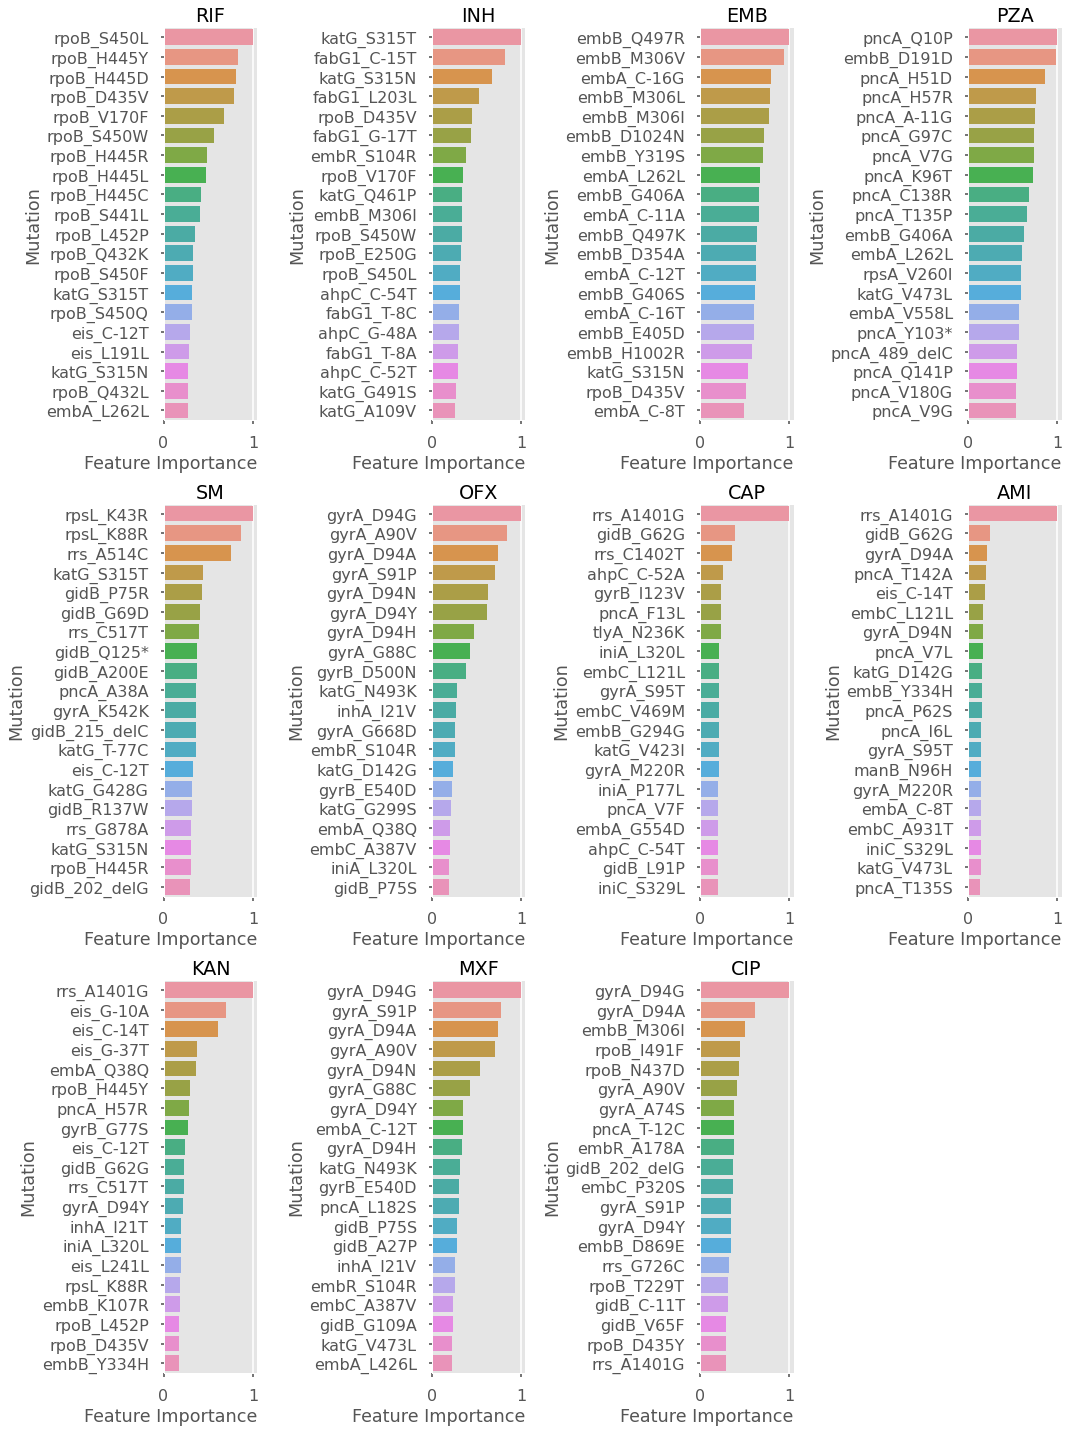

In [8]:

# draw horizontal barplot, each column is a drug, each row is a mutation
fig, ax = plt.subplots(3, 4, figsize=(15, 20))
ax = ax.flatten()
for i, drug in enumerate(plot_drug_list):
    top_mut, top_importance = res_plot[drug]
    # Normalize the feature importance, make the top feature to be 1
    top_importance = top_importance / top_importance[0]

    sns.barplot(x=top_importance, y=top_mut, ax=ax[i])
    ax[i].set_title(drug_dict[drug])
    ax[i].set_xlabel('Feature Importance', loc='right')
    ax[i].set_ylabel('Mutation')
# delete the last empty plot
fig.delaxes(ax[-1])
plt.tight_layout()
plt.savefig('../Figures/res_feature_importance_walker_lr_normal.png')
plt.show()

In [9]:
def getRFFeatureImportance(drug, feature_num = 10):
    # Load the full dataset
    geno_pheno = pd.read_pickle('../Data/Walker2015Lancet.pkl')
    # pick the samples with the drug label 'R' or 'S'
    geno_pheno = geno_pheno[geno_pheno[drug].isin(['R', 'S'])]

    # Get the mutation dictionary
    mutation = geno_pheno['MUTATIONS']
    mut_set = set()
    for i in range(len(mutation)):
        mut_set = mut_set.union(set(mutation[i]))
    mut_list = list(mut_set)
    mut_list.sort()
    mut_dict = dict(zip(mut_list, range(0, len(mut_list))))

    # Get the X and y
    X = np.zeros((len(geno_pheno), len(mut_dict)))
    for i in range(len(geno_pheno)):
        for mut in geno_pheno['MUTATIONS'][i]:
            X[i][mut_dict[mut]] = 1
    y = np.array([1 if y == 'R' else 0 for y in geno_pheno[drug]])

    # Set the random seed
    np.random.seed(0)

    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    # Get the feature importance
    feature_importance = model.feature_importances_
    # Sort the feature importance
    sorted_idx = np.argsort(feature_importance)
    # Get the top 10 features
    top_indices = sorted_idx[-feature_num:]
    # Get the top 10 features
    top_mut = [list(mut_dict.keys())[list(mut_dict.values()).index(idx)] for idx in top_indices]
    # Get the top 10 feature importance
    top_importance = feature_importance[top_indices]

    return top_mut[::-1], top_importance[::-1]

In [10]:
plot_drug_list = ['RIF', 'INH', 'EMB', 'PZA', 'SM', 'OFX', 'CAP', 'AK', 'KAN', 'MOX', 'CIP']
rf_res_plot = {}
for drug in plot_drug_list:
    top_mut, top_importance = getRFFeatureImportance(drug, feature_num = 20)
    rf_res_plot[drug] = (top_mut, top_importance)

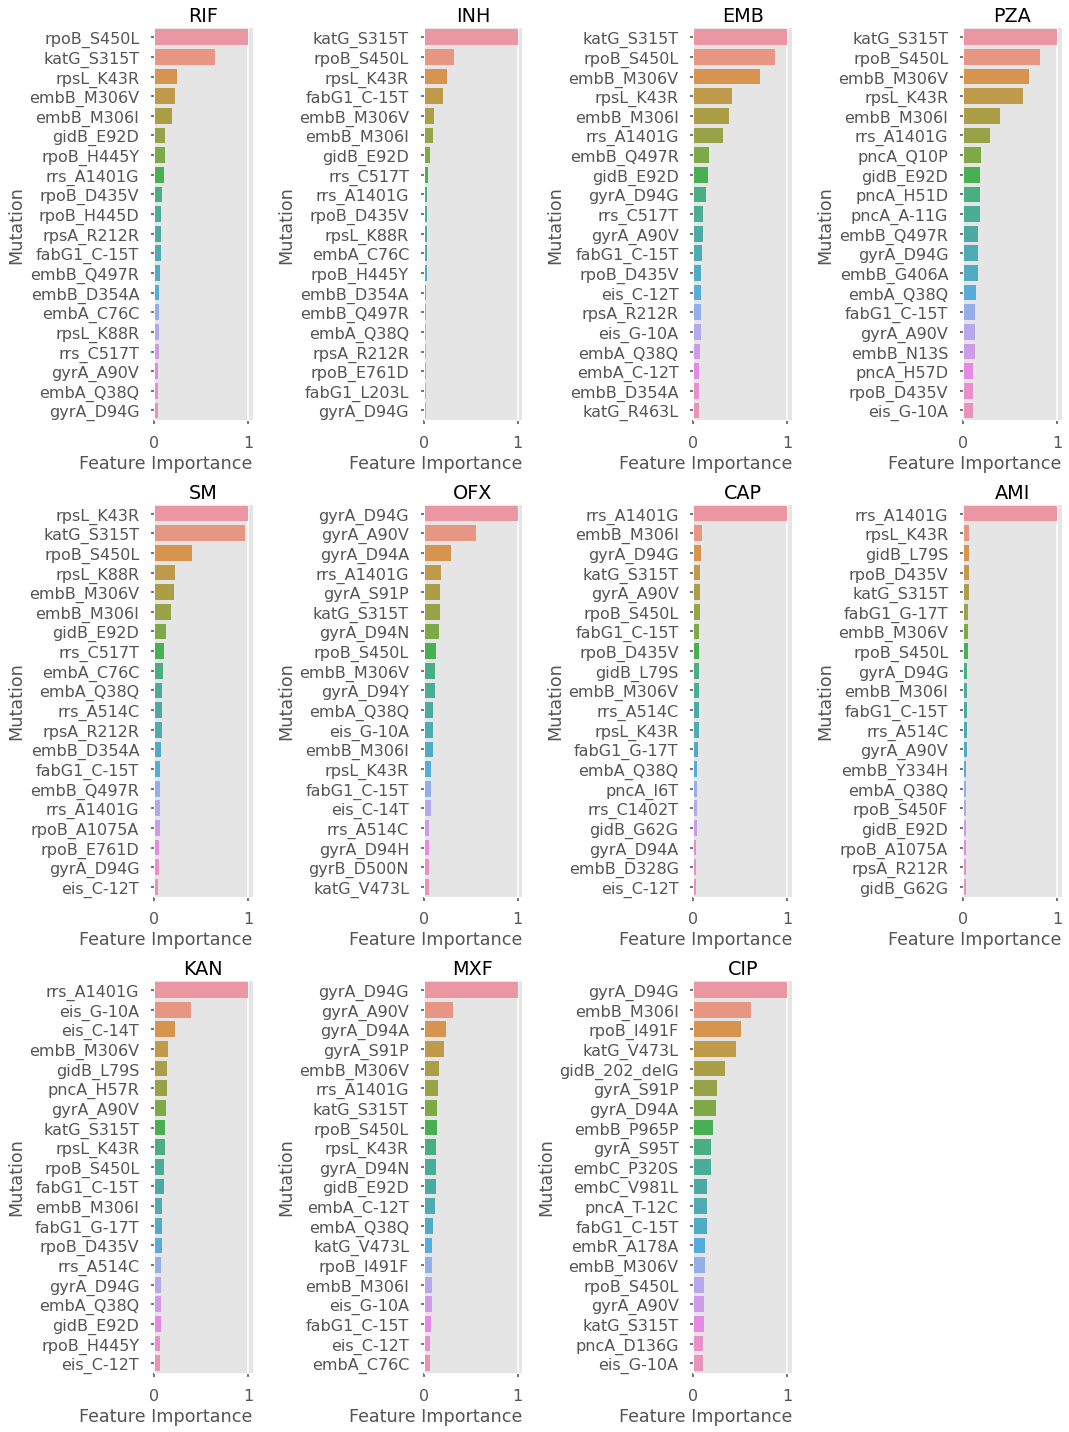

In [11]:
# draw horizontal barplot, each column is a drug, each row is a mutation
fig, ax = plt.subplots(3, 4, figsize=(15, 20))
ax = ax.flatten()
for i, drug in enumerate(plot_drug_list):
    top_mut, top_importance = rf_res_plot[drug]
    # normalize the feature importance, make the top feature to be 1
    top_importance = top_importance / top_importance[0]
    sns.barplot(x=top_importance, y=top_mut, ax=ax[i])
    ax[i].set_title(drug_dict[drug])
    ax[i].set_xlabel('Feature Importance', loc='right')
    ax[i].set_ylabel('Mutation')
# delete the last empty plot
fig.delaxes(ax[-1])
plt.tight_layout()
plt.savefig('../Figures/res_feature_importance_walker_rf_normal.png')
plt.show()

In [1]:
# Get the feature importance from the MTB-HINE-BERT model
import random
import sys
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import BCELoss
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import Adam
"""This file is based on Huggingface Transformer version 4.16.2."""
# from transformers import BertPreTrainedModel, BertModel
from modeling_bert import BertPreTrainedModel, BertModel
from transformers import BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import roc_auc_score

from utils import *

HIDDEN_SIZE = 128  # Same as the dimension of embeddings.
EPOCHS = 100  # Maximum number of epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Model that applies the Bert model to do binary classification.
# Updated based on the class BertForSequenceClassification
class BertBinaryClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=True, # Ask the bert to return a dict
        )

        attentions_output = outputs.attentions
        pooled_output = outputs.pooler_output

        logits = self.dropout(pooled_output)
        logits = self.classifier(logits)
        logits = self.sigmoid(logits)

        loss = None
        if labels is not None:
            loss_fct = BCELoss()
            loss = loss_fct(logits, labels)

        # # if not return_dict:
        # output = (logits,) + (attentions_output,)
        # return ((loss,) + output) if loss is not None else output
        #     # (loss), logits, (attentions)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            # hidden_states=outputs.hidden_states,
            hidden_states=pooled_output,
            attentions=outputs.attentions,
        )


# The data holder contains all data and labels for a drug.
class BertDataset(Dataset):
    def __init__(self, drug):
        self.drug = drug

        # for all keys in the mutation dictionary, set the value to plus 2
        # because 0 and 1 are reserved for padding and [CLS]
        self.mut_dict = getMutDict(drug, split_num=None)
        for key in self.mut_dict:
            self.mut_dict[key] += 2
        self.mut_dict['[CLS]'] = 1

        self.inputs = []
        # Load the dataset for inputs
        with open(f'../Data/idx_splits/Walker_single_binary/{drug}_index.pickle', 'rb') as f:
            indices = pickle.load(f)
        geno_pheno = pd.read_pickle('../Data/Walker2015Lancet.pkl')

        mutations = geno_pheno['MUTATIONS'][indices]
        for muts in mutations:
            self.inputs.append([1] + [self.mut_dict[mut] for mut in muts if mut in self.mut_dict])

        self.labels = getWalkerLabelsAll(drug)

        assert len(self.inputs) == len(self.labels)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.labels[idx], dtype=torch.float)


# function into the dataloader to make the input length the same for each batch
# and to make the input mask
def collate_batch(batch):
    input_list = [item[0] for item in batch]

    # Pad the input tensors to a fixed length with 0s.
    # The size of self.data is [batch_size, sequence length].
    input_ids = torch.nn.utils.rnn.pad_sequence(input_list, batch_first=True)

    # The mask input has the same size with input_ids.
    # 0s and 1s means need and no need to ignore(mask) the input ID.
    attention_masks = torch.tensor(np.where(input_ids != 0, 1, 0))

    labels = torch.tensor([item[1] for item in batch]).unsqueeze(1)

    return input_ids, attention_masks, labels


# the function to load the pretrained embeddings
def load_embeddings(drug):
    mut_dict = getMutDict(drug, split_num=None)
    with open(f'../Data/idx_splits/Walker_single_binary/{drug}_emb_all.pickle', 'rb') as f:
        embeddings = pickle.load(f)

    assert embeddings.shape[-1] == HIDDEN_SIZE
    assert embeddings.shape[0] == len(mut_dict)
    
    # The embedding for '[CLS]' is defined as the average of all snp embeddings.
    # It should be better than a random one, but may still need to improve.
    emb_cls = np.mean(embeddings, axis=0)
    emb_zero = np.zeros_like(emb_cls)
    embeddings = np.vstack([emb_zero, emb_cls, embeddings])

    return torch.tensor(embeddings, dtype=torch.float)


def train_bert(drug):
    # Set the parameters for the model.
    params = {'batch_size': 8, 'num_hidden_layers': 1, 'num_attention_heads': 1, 'learning_rate': 1e-4}

    # load the dataset
    train_dataset = BertDataset(drug)
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=params['batch_size'], collate_fn=collate_batch)

    # Set the configuration of Bert model.
    config = BertConfig(hidden_size=HIDDEN_SIZE,
                        num_hidden_layers=params['num_hidden_layers'],
                        num_attention_heads=params['num_attention_heads'],
                        position_embedding_type='Nothing')
    model = BertBinaryClassification(config)

    # Load the pretrained embeddings.
    embedding_weights = load_embeddings(drug)
    embedding_layer = torch.nn.Embedding.from_pretrained(embedding_weights, freeze=True)
    model.set_input_embeddings(embedding_layer)

    model.to(device)

    # Set the optimizer
    optimizer = Adam(model.parameters(), lr=params['learning_rate'])

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    best_auroc = 0
    best_epoch = 0
    best_model = None

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        for batch in train_dataloader:
            # Unpack the inputs from our dataloader
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # Perform a forward pass
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            # Compute the loss
            loss = outputs['loss']
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters
            optimizer.step()
        
        # Calculate the AUROC on the whole dataset
        model.eval()
        train_logits, train_labels = [], []
        for batch in train_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                logits = outputs['logits']
                train_logits.append(logits.detach().cpu().numpy())
                train_labels.append(b_labels.detach().cpu().numpy())
        train_logits = np.concatenate(train_logits, axis=0)
        train_labels = np.concatenate(train_labels, axis=0)
        train_auroc = roc_auc_score(train_labels, train_logits)
        print(f'{drug} Epoch {epoch + 1} training AUROC: {train_auroc}', end='\r')

        if train_auroc > best_auroc:
            best_auroc = train_auroc
            best_epoch = epoch
            best_model = model.state_dict()
        
        # Early stopping
        if epoch - best_epoch >= 5:
            break

    model.load_state_dict(best_model)
    return model 


def save_feature_rank(drug):
    model = train_bert(drug)
    model.eval()

    mut_dict = getMutDict(drug, split_num=None)
    for key in mut_dict:
        mut_dict[key] += 2
    id_to_mut = {v: k for k, v in mut_dict.items()}

    attn_dict = {}
    mut_ids = torch.tensor(np.arange(2, len(mut_dict)+2), dtype=torch.long)
    split_ids = torch.tensor_split(mut_ids, 20)
    for ids in split_ids:
        input_ids = torch.cat([torch.tensor([1]), ids], dim=0).view(1, -1).to(device)
        output = model(input_ids, output_attentions=True)
        attentions = output['attentions'][0].detach().cpu().numpy().squeeze()
        for j in range(1, ids.shape[0]):
            attn_dict[id_to_mut[ids[j].item()]] = attentions[0, j]
    
    # save the attention scores
    with open(f'../Results/single_binary_classification/Walker/{drug}_bert_attentions.pkl', 'wb') as f:
        pickle.dump(attn_dict, f)


/home/kebl6272/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
plot_drug_list = ['RIF', 'INH', 'EMB', 'PZA', 'SM', 'OFX', 'CAP', 'AK', 'KAN', 'MOX', 'CIP']
for drug in plot_drug_list:
    save_feature_rank(drug)

RIF Epoch 1 training AUROC: 0.9743723761567414
RIF Epoch 2 training AUROC: 0.9759448693315789
RIF Epoch 3 training AUROC: 0.9771726842043789
RIF Epoch 4 training AUROC: 0.9778753107176932
RIF Epoch 5 training AUROC: 0.9800545762969773
RIF Epoch 6 training AUROC: 0.9810296020777499
RIF Epoch 7 training AUROC: 0.9812596019312987
RIF Epoch 8 training AUROC: 0.9816627178417234
RIF Epoch 9 training AUROC: 0.9818956109998438
RIF Epoch 10 training AUROC: 0.9821320404191077
RIF Epoch 11 training AUROC: 0.9821849057372086
RIF Epoch 12 training AUROC: 0.9823441625079878
RIF Epoch 13 training AUROC: 0.982382114805611
RIF Epoch 14 training AUROC: 0.9822044266131155
RIF Epoch 15 training AUROC: 0.9824291935145685
RIF Epoch 16 training AUROC: 0.9826860368049775
RIF Epoch 17 training AUROC: 0.9829149472043356
RIF Epoch 18 training AUROC: 0.9827770151598444
RIF Epoch 19 training AUROC: 0.982879298834427


KeyboardInterrupt: 

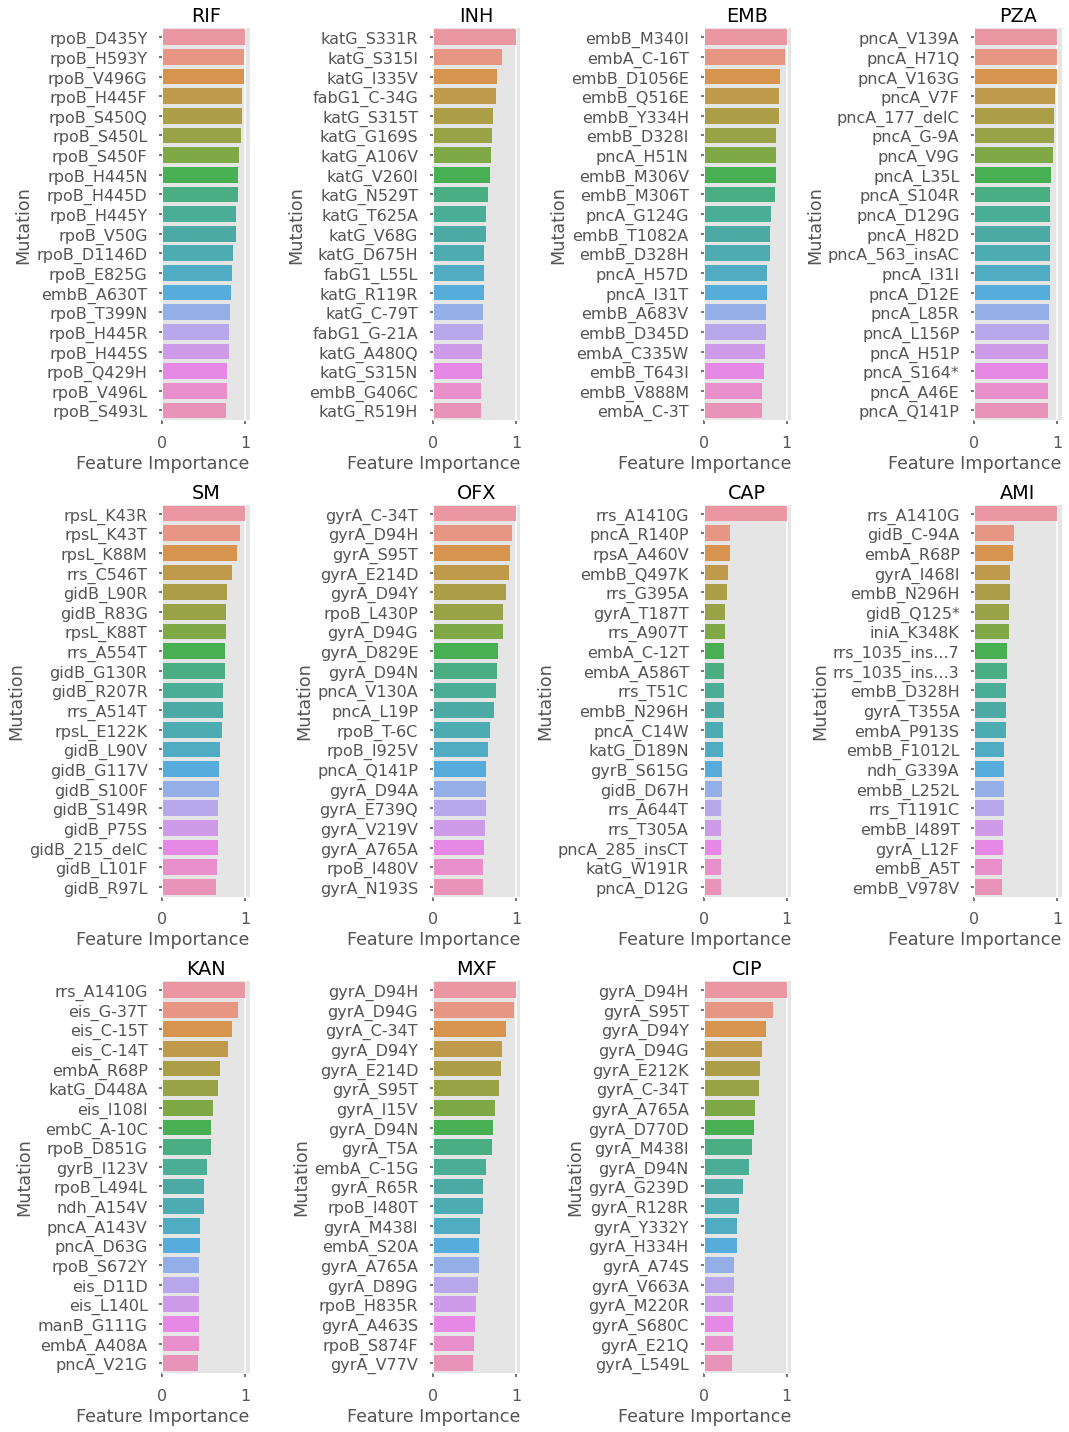

In [15]:
# load the attention scores
attentions = {}
for drug in plot_drug_list:
    with open(f'../Results/single_binary_classification/Walker/{drug}_bert_attentions.pkl', 'rb') as f:
        attentions[drug] = pickle.load(f)

# Edit the names of the mutations to facilitate plotting
attentions['AK']['rrs_1035_ins...7'] = attentions['AK'].pop('rrs_1035_insGTGGAGCA.7')
attentions['AK']['rrs_1035_ins...3'] = attentions['AK'].pop('rrs_1035_insGTGGAGCA.3')

# draw horizontal barplot, each column is a drug, each row is a mutation
fig, ax = plt.subplots(3, 4, figsize=(15, 20))
ax = ax.flatten()
for i, drug in enumerate(plot_drug_list):
    top_mut, top_importance = zip(*sorted(attentions[drug].items(), key=lambda x: x[1], reverse=True)[:20])
    top_mut, top_importance = list(top_mut), list(top_importance)
    # for j in range(len(top_mut)):
    #     if len(top_mut[j]) > 14:
    #         top_mut[j] = top_mut[j][:14] + '...'
    # Normalize the feature importance, make the top feature to be 1
    top_importance = top_importance / top_importance[0]
    sns.barplot(x=top_importance, y=top_mut, ax=ax[i])
    ax[i].set_title(drug_dict[drug])
    ax[i].set_xlabel('Feature Importance', loc='right')
    ax[i].set_ylabel('Mutation')
# delete the last empty plot
fig.delaxes(ax[-1])
plt.tight_layout()
plt.savefig('../Figures/res_feature_importance_walker_bert_normal.png')
plt.show()

In [3]:
# Now we want to train the bert model and record the feature importance for each sample
def save_feature_individual(drug):
    model = train_bert(drug)
    model.eval()

    # Load the dataset for inputs
    with open(f'../Data/idx_splits/Walker_single_binary/{drug}_index.pickle', 'rb') as f:
        indices = pickle.load(f)
    geno_pheno = pd.read_pickle('../Data/Walker2015Lancet.pkl')

    mutations = geno_pheno['MUTATIONS'][indices]
    # ID is the index of geno_pheno
    ids = geno_pheno.index[indices]
    labels = geno_pheno[drug][indices]

    dic_id2mut = {ids[i]: mutations[i] for i in range(len(ids))}
    assert len(dic_id2mut) == len(mutations)
    dic_id2label = {ids[i]: labels[i] for i in range(len(ids))}
    assert len(dic_id2label) == len(labels)

    mut_dict = getMutDict(drug, split_num=None)
    for key in mut_dict:
        mut_dict[key] += 2
    mut_dict['[CLS]'] = 1
    id_to_mut = {v: k for k, v in mut_dict.items()}

    dic_data = {}
    for id in dic_id2mut:
        muts = dic_id2mut[id]
        dic_data[id] = [1] + [mut_dict[mut] for mut in muts if mut in mut_dict]

    # save the attention scores for each sample into a dictionary
    # {id: {attention: {mutation: score}, prediction: prediction, label: label, hidden_state: hidden_state}}
    res = {}
    for id in dic_data:
        input_ids = torch.tensor(dic_data[id], dtype=torch.long).view(1, -1).to(device)
        output = model(input_ids, output_attentions=True)
        attentions = output['attentions'][0].detach().cpu().numpy().squeeze()
        prediction = output['logits'].detach().cpu().numpy().squeeze()
        pooled_output = output['hidden_states'].detach().cpu().numpy().squeeze()
        res[id] = {'attention': {}, 'prediction': prediction, 'label': dic_id2label[id], 'hidden_state': pooled_output}
        for j in range(1, len(dic_data[id])):
            res[id]['attention'][id_to_mut[dic_data[id][j]]] = attentions[0, j]
    
    # save the attention scores
    with open(f'../Results/single_binary_classification/Walker/{drug}_bert_result_individual.pkl', 'wb') as f:
        pickle.dump(res, f)
    

In [4]:
plot_drug_list = ['RIF', 'INH', 'EMB', 'PZA', 'SM', 'OFX', 'CAP', 'AK', 'KAN', 'MOX', 'CIP']
for drug in plot_drug_list:
    save_feature_individual(drug)


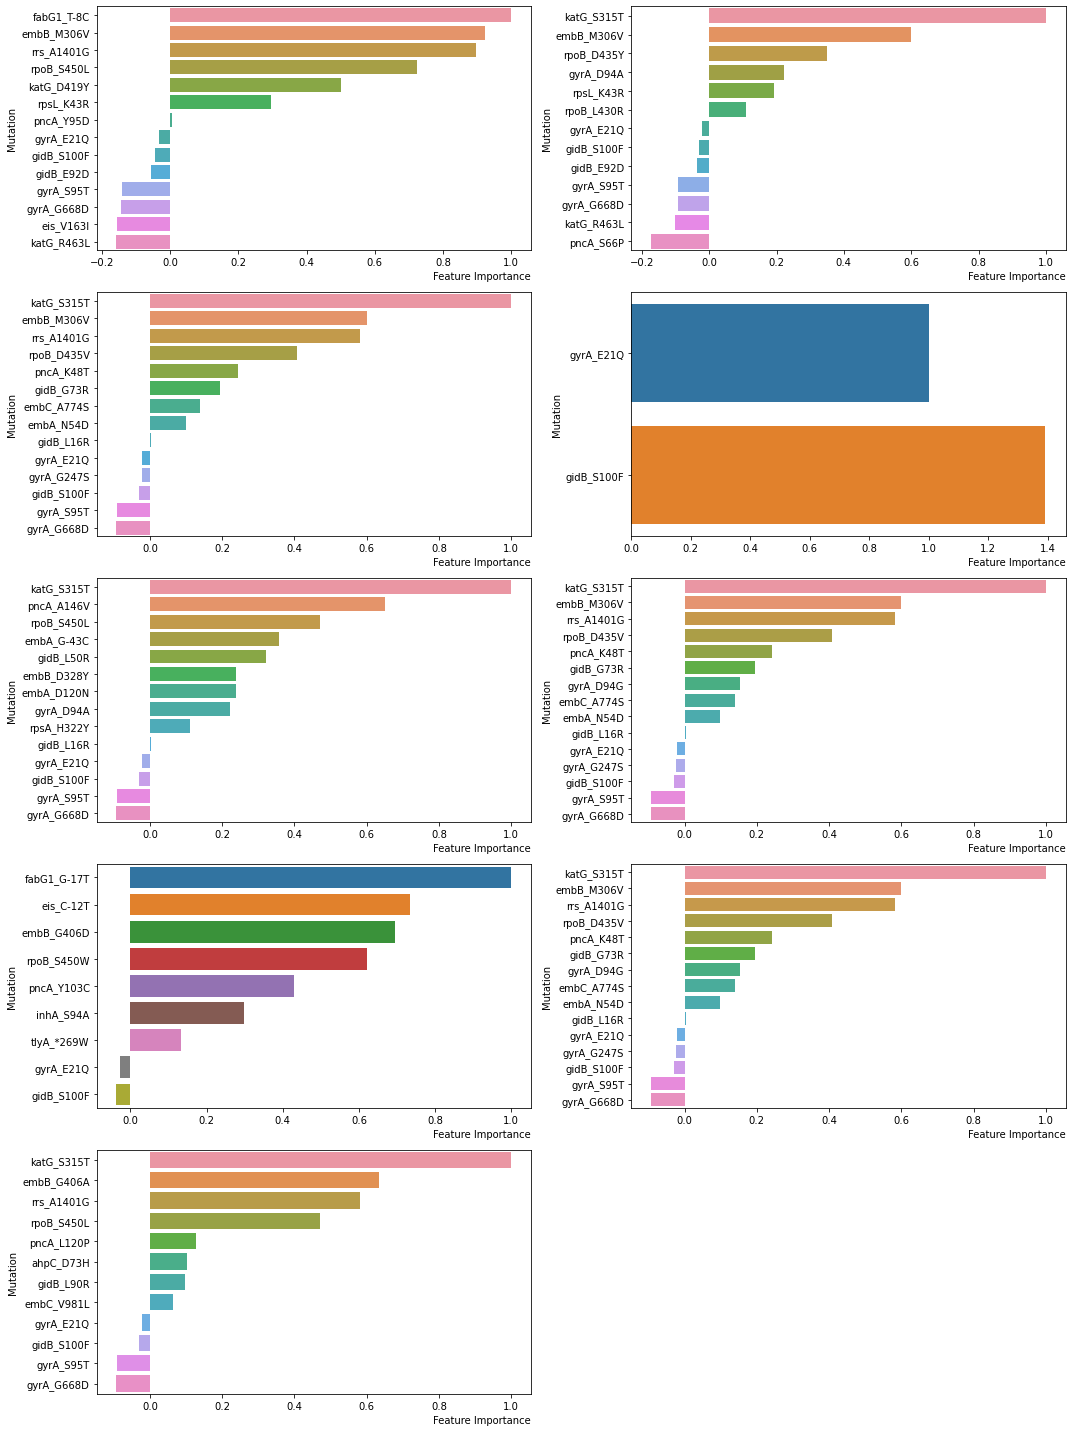

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Now we want to plot the feature importance for the first 10 samples
def plot_individual_attention(drug):
    with open(f'../Results/single_binary_classification/Walker/{drug}_bert_attentions_individual.pkl', 'rb') as f:
        res = pickle.load(f)
    
    # Get the first 10 samples
    ids = list(res.keys())[:10]
    res_plot = {id: res[id] for id in ids}

    # draw horizontal barplot, each column is a drug, each row is a mutation
    fig, ax = plt.subplots(5, 2, figsize=(15, 20))
    ax = ax.flatten()
    for i, id in enumerate(ids):
        attentions = res_plot[id]['attention']
        top_mut, top_importance = zip(*sorted(attentions.items(), key=lambda x: x[1], reverse=True)[:20])
        top_mut, top_importance = list(top_mut), list(top_importance)
        # for j in range(len(top_mut)):
        #     if len(top_mut[j]) > 14:
        #         top_mut[j] = top_mut[j][:14] + '...'
        # Normalize the feature importance, make the top feature to be 1
        top_importance = top_importance / top_importance[0]
        sns.barplot(x=top_importance, y=top_mut, ax=ax[i])
        # ax[i].set_title(f'{drug_dict[drug]} sample {id}')
        ax[i].set_xlabel('Feature Importance', loc='right')
        ax[i].set_ylabel('Mutation')
    # delete the last empty plot
    fig.delaxes(ax[-1])
    plt.tight_layout()
    # plt.savefig(f'../Figures/res_feature_importance_walker_bert_individual_{drug}.png')
    plt.show()

plot_individual_attention('INH')

In [ ]:
# 

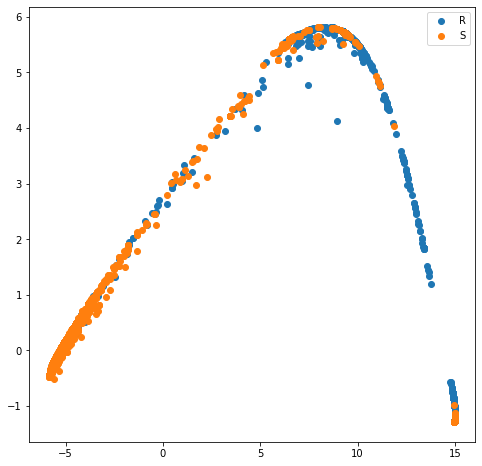

In [10]:
# Extract the hidden states of the samples and plot the t-SNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_individual_2d(drug, method='pca'):
    with open(f'../Results/single_binary_classification/Walker/{drug}_bert_attentions_individual.pkl', 'rb') as f:
        res = pickle.load(f)
    
    # Get the hidden states of all samples
    hidden_states = np.array([res[id]['hidden_state'] for id in res])
    hidden_states = hidden_states.squeeze()

    if method == 'tsne':
        tsne = TSNE(n_components=2, random_state=0)
        res_2d = tsne.fit_transform(hidden_states)
    elif method == 'pca':
        pca = PCA(n_components=2)
        res_2d = pca.fit_transform(hidden_states)

    # Get the drug labels
    labels = [res[id]['label'] for id in res]

    # Plot the t-SNE
    plt.figure(figsize=(8, 8))
    for label in set(labels):
        idx = [i for i in range(len(labels)) if labels[i] == label]
        plt.scatter(res_2d[idx, 0], res_2d[idx, 1], label=label)
    plt.legend()
    # plt.title(f'{drug_dict[drug]} t-SNE')
    plt.show()

plot_individual_2d('INH', method='pca')
